## Import Packages

In [2]:
#import necessary packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


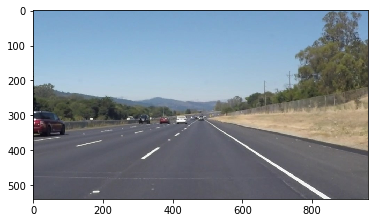

In [3]:
#read in an input image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#print out some stats and plot
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [6]:
#creating image processing methods

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15, cache = None):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_curtain = [200,420]
    right_curtain = [550,800]
    left_lines = []
    right_lines = []
    
    #separate left and right lines by filtering them using a left and right curtain
    for line in lines:
#         print(line)
        for x1,y1,x2,y2 in line:
            if left_curtain[0] < ((x2+x1)/2) < left_curtain[1]:
                left_lines.append(line)
            elif right_curtain[0] < ((x2+x1)/2) < right_curtain[1]:
                right_lines.append(line)
#     print("left lines: ", left_lines, "right_lines: ", right_lines)
#             print(np.average(left_lines, axis = 0))
    #average lines to get one final left and right line
    left_line = np.floor(np.average(left_lines, axis = 0))
    right_line = np.floor(np.average(right_lines, axis = 0))
    try:
        assert len(left_line) == 1
    except:
        left_line = [[100, 540, 450, 324]] [[[100, 540, 450, 324]], [[510, 322, 831, 540]]]
    try:
        assert len(right_line) == 1
    except:
        right_line = [[510, 322, 831, 540]]
#     print(left_line,right_line)
    
    #extrapolate the left and right lines to create clear lane boundaries
    for x1,y1,x2,y2 in left_line:    
        m = ((-y2)-(-y1)) / (x2-x1)
        b = (-y2) - m*x2
        new_y1 = 540
        new_x1 = (-new_y1 - b) / m
        new_x2 = 450
        new_y2 = - ((m * new_x2) + b)
    try:
        left_line = [[int(new_x1),int(new_y1),int(new_x2),int(new_y2)]]
    except:
        left_line = [[100, 540, 450, 324]]
    for x1,y1,x2,y2 in right_line:    
        m = ((-y2)-(-y1)) / (x2-x1)
        b = (-y2) - m*x2
        new_x1 = 510
        new_y1 = - ((m * new_x1) + b)
        new_y2 = 540
        new_x2 = (-new_y2 - b) / m  
    try:
        right_line = [[int(new_x1),int(new_y1),int(new_x2),int(new_y2)]]
    except:
        right_line = [[510, 322, 831, 540]]
    #if video, create cache to stabilize line output using previous line data
#     print('this is cache: ', cache)
    if cache != None:
#         print('yas!')
        if len(cache) > 10:
            cache.pop()
            cache.append([left_line,right_line])
        else:
            cache.append([left_line,right_line])
        left_line, right_line = np.floor(np.average(cache, axis = 0))
#         print(cache)
#     print(left_line,right_line)
    #draw lines
    for line in [left_line,right_line]:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, cache = None):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, cache = cache)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

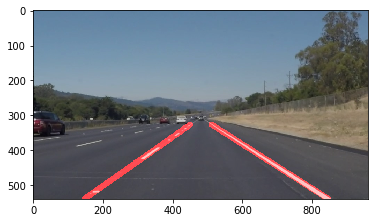

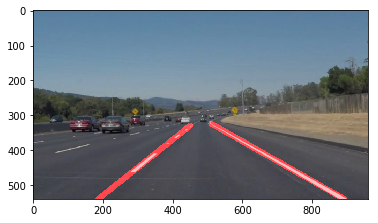

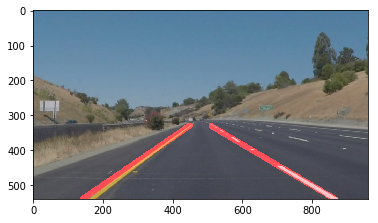

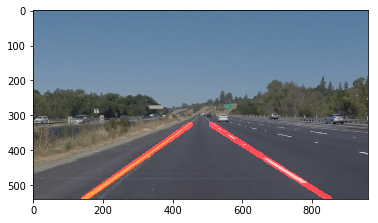

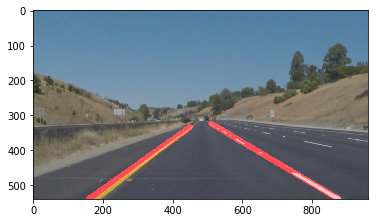

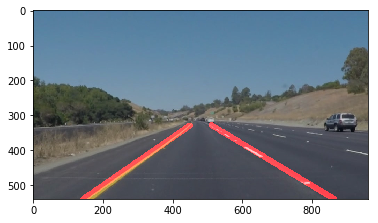

In [8]:
# build image processing pipeline

for img in os.listdir("test_images/"):

    #read image from file
    image = mpimg.imread("test_images/" + img)
#     print(image.shape)
    #grayscale the image
    gray_image = grayscale(image)

    #add gaussian blur to image
    kernel_size = 5
    gaussian_image = gaussian_blur(image, kernel_size)

    #apply canny edge detection to return edges
    low_threshold = 50
    high_threshold = 150
    edges = canny(image, low_threshold, high_threshold)

    #applying rectangular mask to retun masked_edges
    vertices = np.array([[(0,image.shape[0]),(450, 290), (490, 290), (image.shape[1],image.shape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)

    #applying Hough transform and return line_image
    hough_image = hough_lines(masked_image, rho = 1, theta = np.pi/180, threshold = 80, min_line_len = 100, max_line_gap = 120)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    line_edges = weighted_img(hough_image, image)
    fig = plt.figure()
    plt.imshow(line_edges)
    plt.savefig("output_images/" + img)
 

In [8]:
#test on videos!

# import libraries needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
cache = []
def process_image(image):
    
    #grayscale the image
    gray_image = grayscale(image)

    #add gaussian blur to image
    kernel_size = 5
    gaussian_image = gaussian_blur(image, kernel_size)

    #apply canny edge detection to return edges
    low_threshold = 50
    high_threshold = 150
    edges = canny(image, low_threshold, high_threshold)

    #applying rectangular mask to retun masked_edges
    vertices = np.array([[(0,image.shape[0]),(450, 290), (490, 290), (image.shape[1],image.shape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)

    #applying Hough transform and return line_image
    hough_image = hough_lines(masked_image, rho = 1, theta = np.pi/180, threshold = 40, min_line_len = 60, max_line_gap = 250)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    result = weighted_img(hough_image, image)

    return result

In [12]:
#processing on video with solid white lane lines
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 14.3 s, sys: 1.1 s, total: 15.4 s
Wall time: 32.9 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
#processing the video with yellow lane lines
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 3/681 [00:00<00:39, 17.12it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



t:  85%|████████▍ | 577/681 [01:24<00:16,  6.34it/s, now=None]

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [15]:
#processing video with curved lane lines
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:49<00:00,  4.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 20.7 s, sys: 1.06 s, total: 21.8 s
Wall time: 53 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))